In [14]:
# MNIST 패션 dataset 전처리

import numpy as np
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [15]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지를 정규화하고 크기를 변경합니다.
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

### 파라미터 구성

In [16]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 64
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

### Encoder 구성


인코더의 역할은 입력 이미지를 받아 잠재 공간 안의 임베딩 벡터에 매핑하는 것.  
여기서는 32x32x1(0~255 픽셀값)의 이미지를 받아 2D 벡터로 변형한다.

In [1]:
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras.backend as K

encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:] # 디코더에 필요

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

NameError: name 'EMBEDDING_DIM' is not defined

### Decoder 구성

인코더에서 압축된 2D 벡터를 다시 원래 이미지 값으로 출력합니다.  
합성곱 층 대신 전치 합성곱 층(transposed convolutional layer)을 사용합니다.  

In [19]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')

# 입력을 Dense 층에 연결합니다.
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# 전치 합성곱 층에 입력으로 주입할 수 있도록 Reshape 층을 통해 벡터의 크기를 바꿉니다.
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(1, (3, 3), strides = 1, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### 오토인코더 훈련

인코더, 디코더 연결

In [20]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
opt = optimizers.Adam(learning_rate=0.0005)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.4070 - val_loss: 0.2750
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2721 - val_loss: 0.2674
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2645 - val_loss: 0.2628


In [23]:
autoencoder.save('./models/autoencoder.keras')
encoder.save('./models/encoder.keras')
decoder.save('./models/decoder.keras')

## 잠재 공간 확인

임베딩 공간 시각화
원본과 오토디코더로 생성한 사본 비교

In [24]:
example_images = x_test[:5000]
example_labels = y_test[:5000]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


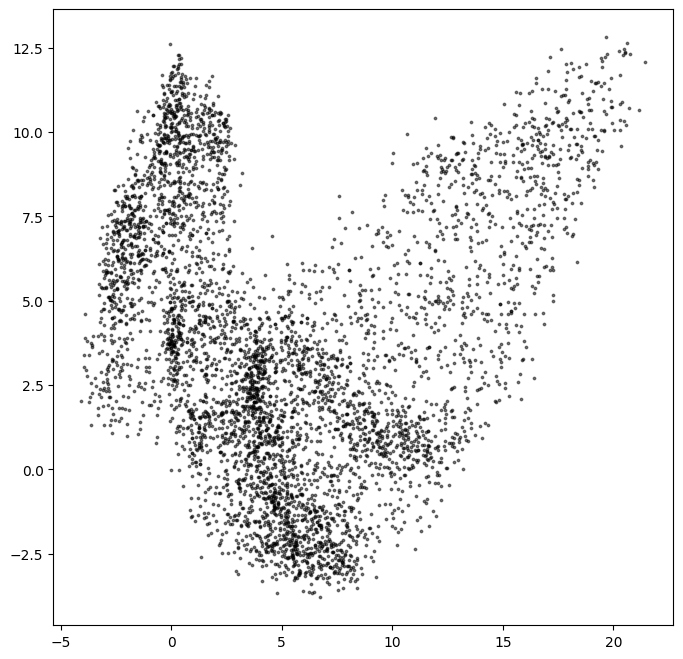

In [25]:
import matplotlib.pyplot as plt

embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

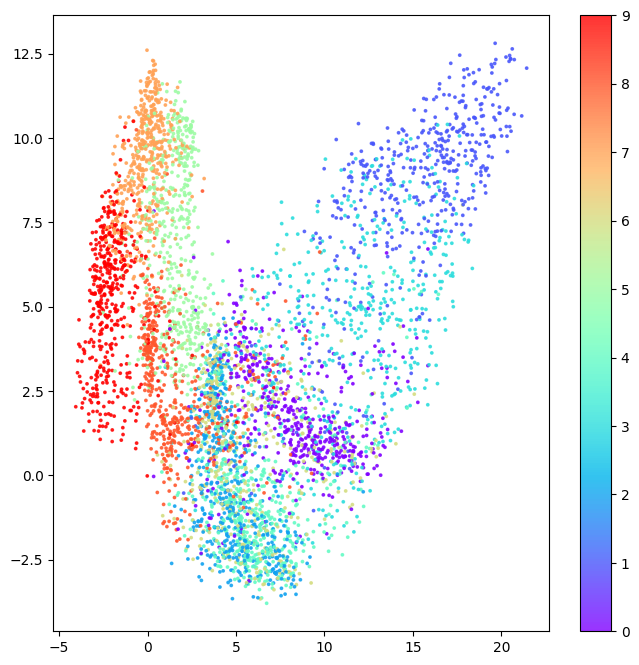

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [30]:
predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


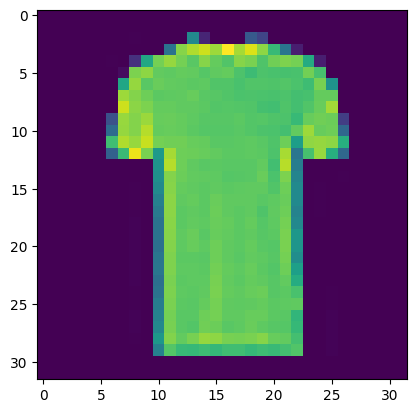

In [37]:
plt.imshow(example_images[88])

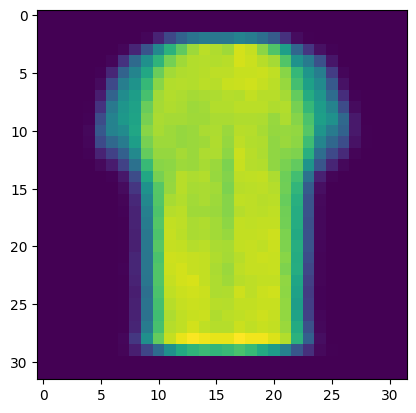

In [38]:
plt.imshow(predictions[88])

### 디코더를 이용한 생성

잠재 공간의 일부 포인트를 샘플링하고 디코더를 사용하여 새로운 이미지 생성

In [40]:
# 기존의 임베딩 범위 구하기
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# 임베딩 공간에서 포인트를 샘플링
grid_width, grid_height = (6, 3)
sample = np.random.uniform(mins, maxs, size=(grid_width*grid_height, EMBEDDING_DIM))

In [41]:
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


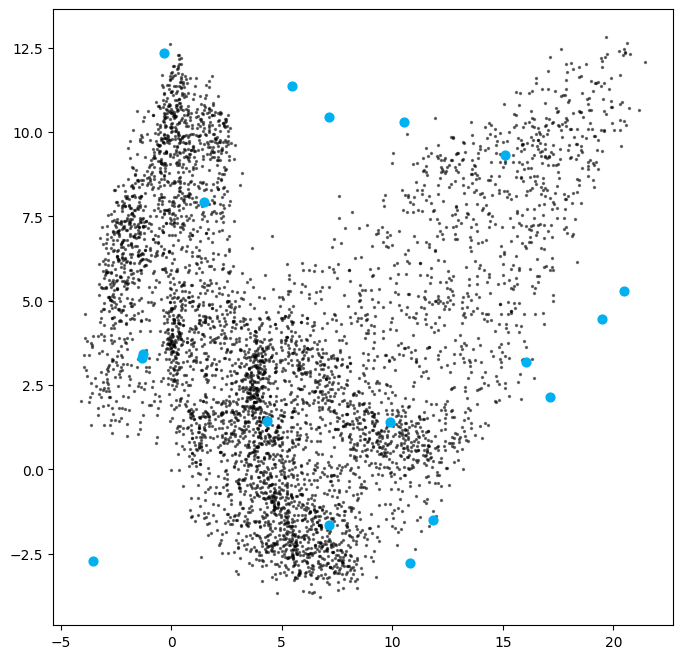

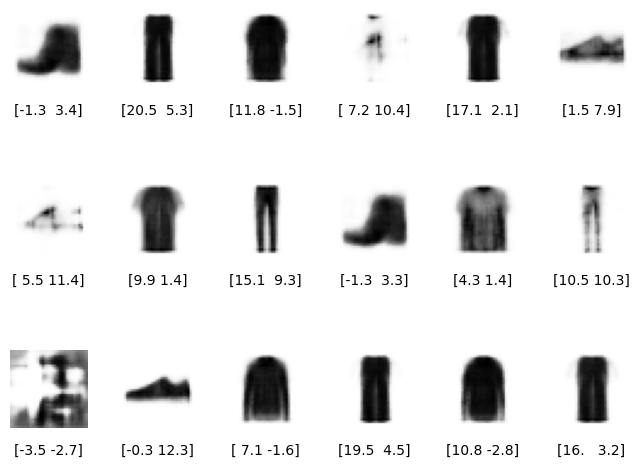

In [42]:
# 그래프로 그립니다.
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에서 새로 생성된 포인트
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드 추가
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")